# <strong>第三次作品：分類器評比 PART2 - AT&T 人臉影像</strong>
學號：711233117

姓名：楊廷紳

 <font color=skyblue>作品目標</font>：

利用機器學習技術，對 AT&T 人臉影像資料集中的人臉影像進行分類。這個資料集包含了多個人的多張灰度人臉影像，每個人大約有10張不同表情和姿勢的影像。我們將利用這些影像來訓練一個分類器，使其能夠準確地識別不同的人臉。

在這個作品中將採用多個機器學習算法，如支持向量機（SVM）、類神經網路等，通過訓練模型來對人臉影像進行分類。我們將使用AT&T人臉影像資料集，將其切分為訓練集和測試集，並對模型進行評估和優化，以確保模型的準確性和泛化能力。

通過完成這個作品，目標是建立一個準確的人臉影像分類器，能夠根據人臉影像的特徵來識別不同的人臉，從而為人臉識別和相關應用提供可靠的技術支持。
 <hr>

### **匯入需要使用之套件**

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression , LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import  GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import accuracy_score , classification_report
import warnings
import random
from datetime import datetime

import matplotlib.pyplot as plt
from numpy.linalg import eig
from matplotlib.ticker import PercentFormatter
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore') #處理 warning 結果
# 設置種子碼
random.seed(38)

### 載入 AT&T 人臉影像資料

資料集包含了40位受試者的400張灰度人臉影像，每個受試者都提供了10張不同表情和姿勢的影像。每張影像都是灰度影像，大小為92x112像素。使用蒙太奇矩陣初步觀察資料，將大小調成 64*64 的像素大小，只呈現 10 個不同人的影像。

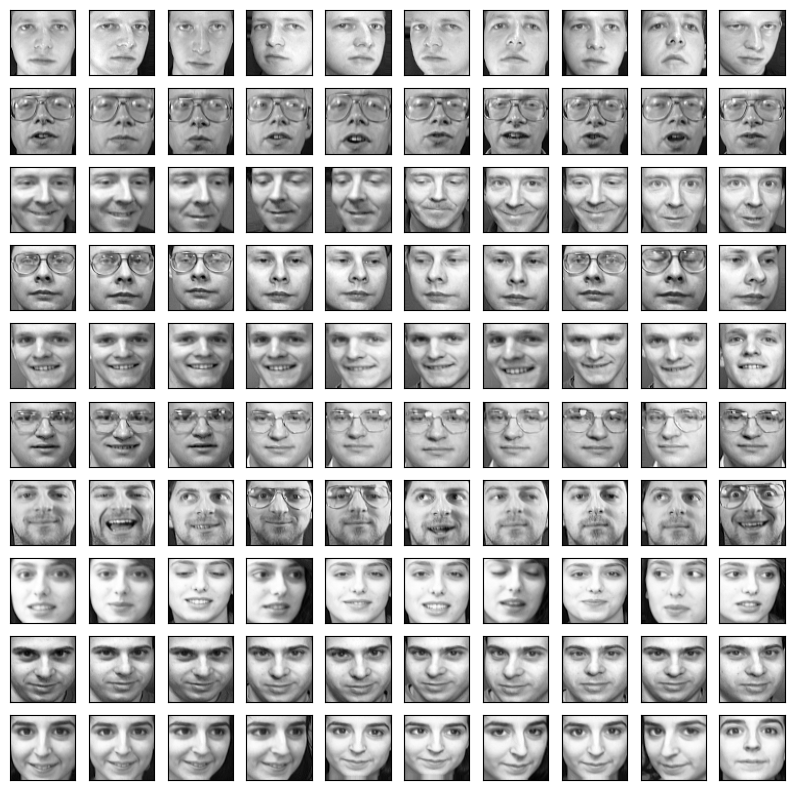

In [2]:
import scipy.io
import os

def show_montage(X, n, m, h, w):
    '''
    X: 影像資料矩陣，每行代表一張影像
    n,m: 每張影像的大小 nxm
    h,w: 建立一個蒙太奇圖陣，大小 figsize=(w,h)
    '''
    fig, axes = plt.subplots(h, w, figsize=(w, h))
    if X.shape[1] < w * h: 
        X = np.c_[X, np.zeros((X.shape[0], w*h - X.shape[1]))]
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[:,i].reshape(m, n), cmap='gray') #.T
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

df = pd.read_csv('/Users/samuel/Documents/vscode_python/face_data.csv')
n_persons = df['target'].nunique() #不同人臉
X = np.array(df.drop('target', axis=1))
y = np.array(df['target'])
n, m = 64, 64 #將大小調成 64*64
#初步觀察影像資料
show_montage(X.T, n , m , 10, 10) #40 個人 每個人 10 張 #只列 10 個人

### **原始資料進行切割並標準化資料**

In [3]:
# Read data
X = np.array(df.iloc[:, :-1]) # 排 除 最 後 一 欄 標 籤
y = np.array(df.iloc[:, -1]) # 標籤欄
# Split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# Standardize data
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.fit_transform(X_test)

### <font color=yellow> 標準化的用意 </font>
對於某些機器學習模型，如邏輯斯回歸和支持向量機（SVM）等，影像資料的標準化通常是有助於模型收斂和性能的。標準化可以使得每個特徵的平均值為0，標準差為1，這樣可以幫助模型更快地收斂到最優解。

另一方面，在某些深度學習模型中，如卷積神經網路（CNN），影像資料通常不需要嚴格的標準化，因為這些模型可以自行學習到特徵的分佈和變化。

因此，是否對影像資料進行標準化取決於所使用的模型以及具體的應用場景。在實際應用中，可以試驗不同的方法，觀察模型的效果，並根據需要進行調整。

<hr>

## <font color=orange> 原始資料模型測試 </font> 
該段落會以原始資料，經過標準化後進行模型訓練。直接進行單次預測，觀察預測效益。因為影像資料的訓練成本較大，後續使用奇異值分解降維資料在尋找參數做模型優化。

### <font color=orange> 羅吉斯迴歸 (Logistic Regression) </font> 

In [4]:
opts = dict(tol = 1e-6, max_iter = int(1e6), verbose=1)
# solver = 'lbfgs' # ’lbfgs’ is the default # 2 min
# solver = 'liblinear' # 19 s
solver = 'newton-cg' # 4 s
clf_original = LogisticRegression(solver = solver, **opts)
clf_original.fit(X_train_, y_train)
y_pred = clf_original.predict(X_test_)

# 測 試 資 料 之 準 確 率 回 報
print(f'Test set classification accuracy of Logistic Regression:{accuracy_score(y_test, y_pred):.2%}\n')
print(f'Test set classification accuracy of Logistic Regression:{clf_original.score(X_test_, y_test):.2%}\n')
print('---------------------------------------------------------------------------')
print(classification_report(y_test, y_pred))

Test set classification accuracy of Logistic Regression:95.00%

Test set classification accuracy of Logistic Regression:95.00%

---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      0.75      0.86         8
           8       1.00      1.00      1.00         2
           9       0.75      1.00      0.86         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         5
          12       0.67      1.00      0.80         2
          13       1.00      1.00      

In [5]:
opts = dict(tol = 1e-6, max_iter = int(1e6)) # parameters for LogisticRegression
params_log = {'solver':['liblinear', 'newton-cg'], 'C':[0.1, 1, 10]} # parameters for GridSearchCV
# parameters = {'solver':['lbfgs', 'liblinear', 'newton-cg','sag','saga']} # saga sag 求解器訓練時間太久

cv = StratifiedShuffleSplit(n_splits=4, test_size=0.3,random_state=0) # 5-fold CV
grid_lr_best = GridSearchCV(estimator=LogisticRegression(**opts), param_grid=params_log, cv=cv, scoring=['accuracy','f1_macro'], refit="accuracy")
grid_lr_best.fit(X_train_, y_train)

print(grid_lr_best.best_params_)                            
print(grid_lr_best.best_score_)                                 
print(grid_lr_best.best_estimator_) 

{'C': 10, 'solver': 'newton-cg'}
0.9613095238095238
LogisticRegression(C=10, max_iter=1000000, solver='newton-cg', tol=1e-06)


### <font color=orange> 支持向量機 (Support Vector Machine)</font> 

In [6]:
opts = dict(C = 10, tol = 1e-6, max_iter = int(1e6))

svm_clf_original = SVC(kernel = 'linear', **opts) #poly 預測不好
svm_clf_original.fit(X_train_, y_train)
y_pred = svm_clf_original.predict(X_test_)

print(f'Test set classification accuracy of Support Vector Machine:{accuracy_score(y_test, y_pred):.2%}\n')
print(f'Test set classification accuracy of Support Vector Machine:{svm_clf_original.score(X_test_, y_test):.2%}\n')
print('---------------------------------------------------------------------------')
print(classification_report(y_test, y_pred))

Test set classification accuracy of Support Vector Machine:95.00%

Test set classification accuracy of Support Vector Machine:95.00%

---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      0.75      0.86         8
           8       1.00      1.00      1.00         2
           9       0.75      1.00      0.86         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         5
          12       0.67      1.00      0.80         2
          13       1.00      1.00

### <font color=orange> 類神經網路 (Artificial Neural Network)</font> 

In [7]:
hidden_layers = (20, 20)
activation = 'relu'
opts = dict(hidden_layer_sizes = hidden_layers, verbose = False, activation = activation, tol = 1e-6, max_iter = int(1e6))
# solver = ’sgd’ # not efficient, need more tuning # solver = ’lbfgs’ # not suitable here
solver = 'lbfgs' # default solver
Ann_clf_original = MLPClassifier(solver = solver, random_state = 8, **opts)
Ann_clf_original.fit(X_train_, y_train)
y_pred= Ann_clf_original.predict(X_test_)

print(f'Test set classification accuracy of Neural Network:{accuracy_score(y_test, y_pred):.2%}\n')
print(f'Test set classification accuracy of Neural Network:{Ann_clf_original.score(X_test_, y_test):.2%}\n')
print('---------------------------------------------------------------------------')
print(classification_report(y_test, y_pred))

Test set classification accuracy of Neural Network:83.33%

Test set classification accuracy of Neural Network:83.33%

---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       1.00      1.00      1.00         4
           2       1.00      0.50      0.67         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      0.67      0.80         3
           7       1.00      0.50      0.67         8
           8       0.67      1.00      0.80         2
           9       0.75      1.00      0.86         3
          10       0.43      1.00      0.60         3
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         2
          13       1.00      0.33      0.50      

由於原始資料集的龐大，模型訓練的成本相對較高。這是因為資料集中包含了大量的資料點和特徵，需要花費更多的計算資源和時間來處理和訓練。在訓練過程中，模型需要進行大量的參數更新和梯度計算，並且可能需要多次遍歷整個資料集才能收斂到最佳的解。這將需要更多的記憶體和計算資源，並且可能會導致訓練時間的增加。

<hr>

## <font color=orange> 降維資料模型測試 </font> 

對影像資料進行<font color=yellow> 奇異值分解（SVD）</font>是一種常見的降維技術，可以將高維的影像資料轉換為低維的表示，同時保留了大部分重要的資訊。這對於影像處理和分析來說是一個非常有用的技術。SVD的過程可以幫助我們對影像資料進行降維，同時保留了大部分重要的資訊，從而更有效地進行影像處理和分析。但是還是須先選擇適當的主成分個數。

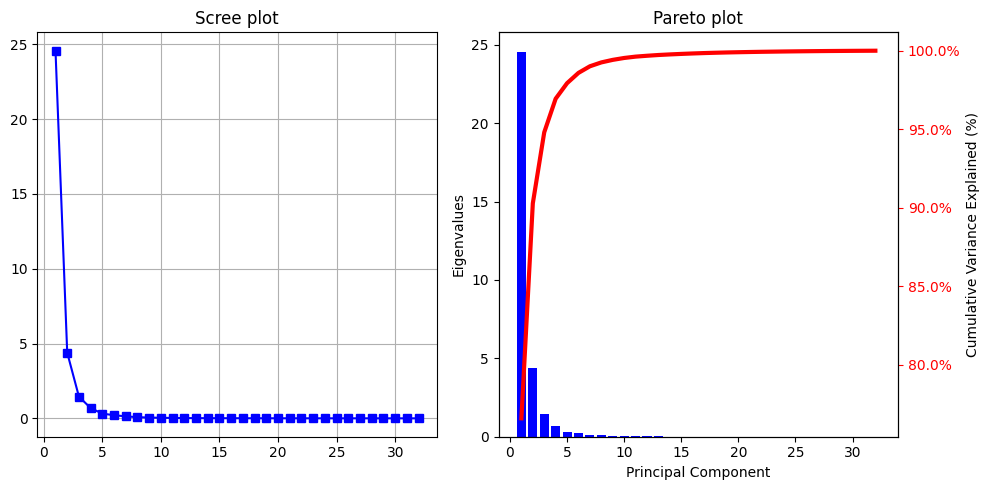

In [8]:
ratings = np.array(df)
# Standardize the ratings
scaler = StandardScaler()
ratings_ = scaler.fit_transform(ratings)

# Assuming you already have defined ratings_ and calculated s_x_npfun
s_x_npfun = np.cov(ratings_[:, 0:32].T, bias=False)
w, v = eig(s_x_npfun)
idx = np.argsort(w)[::-1]
eigvals = w[idx]
eigvecs = v[:, idx]
Sigma_x = eigvecs @ np.diag(eigvals) @ eigvecs.T

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with two sub

# Scree plot
x = np.arange(1, 1+len(eigvals))
ax1.plot(x, eigvals, marker='s', color= 'blue')
ax1.set_title('Scree plot')
ax1.grid(True)

# Pareto plot
ax2.bar(x, eigvals , color = 'blue')
ax3 = ax2.twinx()
ax3.plot(x, eigvals.cumsum()/eigvals.sum()*100, color='red', lw=3) #,marker='s'
ax3.tick_params(axis='y', colors='red')
ax3.yaxis.set_major_formatter(PercentFormatter())
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Eigenvalues')
ax3.set_ylabel('Cumulative Variance Explained (%)')
ax2.set_title('Pareto plot')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

選擇<font color=yellow>約 13 </font>個主成分能解釋的變異量不再提升，且能解釋將近 100% 的變異。這裡選擇到 <font color=yellow>30</font> 個主成分個數，原因為當主成分個數更多時，模型預測能力也有顯著的提升。

In [9]:
from sklearn.decomposition import TruncatedSVD
# 建立TruncatedSVD模型並擬合訓練資料
svd = TruncatedSVD(n_components=30).fit(X_train_) #4096~30
# 將訓練和測試資料進行降維
Z_train = svd.transform(X_train_)
Z_test = svd.transform(X_test_)

# from sklearn.decomposition import PCA
# pca = PCA(n_components = 14).fit(X_train_)
# Z_train = pca.transform(X_train_)
# Z_test = pca.transform(X_test_)

 ### <font color=orange> SVD 資料 - 羅吉斯模型</font> 

In [10]:
opts = dict(tol = 1e-6, max_iter = int(1e5), verbose=False)
#solver = 'lbfgs' # ’lbfgs’ is the default
#solver = 'liblinear'
solver = 'newton-cg'
clf_pca = LogisticRegression(solver = solver, **opts)
clf_pca.fit(Z_train, y_train)
y_pred = clf_pca.predict(Z_test)

# 測 試 資 料 之 準 確 率 回 報
print(f'Test set classification accuracy of Logistic Regression:{accuracy_score(y_test, y_pred):.2%}\n')
print(f'Test set classification accuracy of Logistic Regression:{clf_pca.score(Z_test, y_test):.2%}\n')
print('---------------------------------------------------------------------------')
print(classification_report(y_test, y_pred))

Test set classification accuracy of Logistic Regression:94.17%

Test set classification accuracy of Logistic Regression:94.17%

---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       0.67      0.67      0.67         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      0.75      0.86         8
           8       1.00      1.00      1.00         2
           9       0.75      1.00      0.86         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         5
          12       0.67      1.00      0.80         2
          13       1.00      1.00      

 ### <font color=orange> SVD 資料 - SVM 模型</font> 

In [11]:
opts = dict(C = 10, tol = 1e-6, max_iter = int(1e6))

svm_clf_original = SVC(kernel = 'rbf', **opts)
svm_clf_original.fit(Z_train, y_train)
y_pred = svm_clf_original.predict(Z_test)

print(f'Test set classification accuracy of Support Vector Machine:{accuracy_score(y_test, y_pred):.2%}\n')
print(f'Test set classification accuracy of Support Vector Machine:{svm_clf_original.score(Z_test, y_test):.2%}\n')
print('---------------------------------------------------------------------------')
print(classification_report(y_test, y_pred))

Test set classification accuracy of Support Vector Machine:91.67%

Test set classification accuracy of Support Vector Machine:91.67%

---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      0.62      0.77         8
           8       0.67      1.00      0.80         2
           9       0.60      1.00      0.75         3
          10       1.00      1.00      1.00         3
          11       1.00      0.80      0.89         5
          12       0.67      1.00      0.80         2
          13       1.00      1.00

 ### <font color=orange> SVD 資料 - ANN模型</font> 

In [12]:
hidden_layers = (30)
activation = 'relu'
opts = dict(hidden_layer_sizes = hidden_layers, verbose = False, activation = activation, tol = 1e-6, max_iter = int(1e6))
# solver = ’sgd’ # not efficient, need more tuning # solver = ’lbfgs’ # not suitable here
solver = 'lbfgs' # default solver
Ann_clf_original = MLPClassifier(solver = solver, random_state = 8, **opts)
Ann_clf_original.fit(Z_train, y_train)
y_pred= Ann_clf_original.predict(Z_test)

print(f'Test set classification accuracy of Neural Network:{accuracy_score(y_test, y_pred):.2%}\n')
print(f'Test set classification accuracy of Neural Network:{Ann_clf_original.score(Z_test, y_test):.2%}\n')
print('---------------------------------------------------------------------------')
print(classification_report(y_test, y_pred))

Test set classification accuracy of Neural Network:82.50%

Test set classification accuracy of Neural Network:82.50%

---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       1.00      1.00      1.00         4
           2       1.00      0.50      0.67         2
           3       1.00      0.75      0.86         4
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         3
           6       1.00      0.67      0.80         3
           7       1.00      0.62      0.77         8
           8       0.67      1.00      0.80         2
           9       0.60      1.00      0.75         3
          10       0.75      1.00      0.86         3
          11       0.75      0.60      0.67         5
          12       0.50      1.00      0.67         2
          13       1.00      1.00      1.00      

奇異值分解（SVD）在機器學習中有許多應用，特別是在降維和特徵提取方面。以下是SVD運用在機器學習模型中的一些好處：

- <font color=yellow>降低維度</font> : SVD可以將高維度的資料轉換為低維度的表示，從而減少資料的複雜度和計算成本。這對於處理大規模資料和高維度特徵的應用非常有用，可以提高模型的效率和性能。

- <font color=yellow>去除噪聲</font> : SVD可以幫助我們去除資料中的噪聲和不必要的變動，從而提高模型的魯棒性和泛化能力。通過保留最重要的特徵，可以減少過擬合的風險，使模型更加準確地捕捉到資料的本質。

- <font color=yellow>特徵提取</font> : SVD可以幫助我們提取資料中的主要特徵，從而更好地理解資料的結構和模式。這些特徵可以用於後續的模型訓練和預測，從而提高模型的性能和準確度。

- <font color=yellow>可解釋性</font> : SVD轉換後的低維表示通常更容易解釋和理解，因為它們包含了原始資料的主要變異性。這使得我們能夠更好地理解模型的預測結果和特徵之間的關係，從而做出更明智的決策。

總歸來說，SVD在機器學習模型中的應用可以幫助我們處理高維度和大規模的資料，提高模型的效率、準確性和可解釋性。它是一個強大的工具，可以應用於各種機器學習任務中，包括分類、迴歸、聚類等。

<hr>

## <font color=orange> 參數優化之模型訓練 </font> 

使用 `Pipeline` 可以將多個資料處理步驟串連起來，以便更容易地對整個流程進行訓練、調整參數和評估模型。在 Pipeline 中，各個步驟依次應用，並且每個步驟的輸出將作為下一個步驟的輸入。這對於避免資料洩露和簡化程式碼結構都非常有用。

In [26]:
from sklearn.pipeline import Pipeline

# 定義 svd Pipeline
pipe_svd_lr = Pipeline([
    # ('svd', TruncatedSVD()),
    ('lr', LogisticRegression())
])

pipe_svd_svm = Pipeline([
    ('svm', SVC())
])

pipe_svd_ann = Pipeline([
    ('ann', MLPClassifier())
])

In [27]:
# 定義svd參數範圍 #物件名稱要打對 (_ _)
params_svd_lr = {
    #'svd__n_components': [30],  # 調整降維後的維度 #, 40
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear']
}

params_svd_svm = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

params_svd_ann = {
    'ann__hidden_layer_sizes': [(20,), (30,), (30, 30)],
    'ann__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'ann__solver': ['lbfgs', 'adam'] #, 'sgd'
}

In [28]:
# 定義 GridSearchCV
grid_svd_lr = GridSearchCV(pipe_svd_lr, params_svd_lr, cv=4)
grid_svd_svm = GridSearchCV(pipe_svd_svm, params_svd_svm, cv=4)
grid_svd_ann = GridSearchCV(pipe_svd_ann, params_svd_ann, cv=4)

# 進行交叉驗證調整參數並找到最好的模型
grid_svd_lr.fit(Z_train, y_train)
grid_svd_svm.fit(Z_train, y_train)
grid_svd_ann.fit(Z_train, y_train)

GridSearchCV(cv=4, estimator=Pipeline(steps=[('ann', MLPClassifier())]),
             param_grid={'ann__activation': ['identity', 'logistic', 'tanh',
                                             'relu'],
                         'ann__hidden_layer_sizes': [(20,), (30,), (30, 30)],
                         'ann__solver': ['lbfgs', 'adam']})

上述程式碼定義了三個使用了奇異值分解（SVD）的Pipeline，分別用於羅吉斯迴歸（Logistic Regression）、支持向量機（Support Vector Machine，SVM）和人工神經網路（Artificial Neural Network，ANN）模型。接著使用 `GridSearchCV` 來進行交叉驗證調整參數，找到最好的模型。

這些Pipeline和GridSearchCV的結構相似，都是根據指定的參數範圍對模型進行訓練和調參。<font color=skyblue>這裡有幾個值得注意的地方</font>：

1. <font color=skyblue>參數範圍設置</font>: 定義了不同模型的參數範圍，包括SVD的降維維度以及各個模型的相關參數（如羅吉斯迴歸的solver、支持向量機的C和kernel、人工神經網路的hidden_layer_sizes、activation和solver等）。

2. <font color=skyblue>交叉驗證</font>: 使用GridSearchCV對每個模型進行交叉驗證調參，這有助於選擇最佳的參數組合，提高模型的泛化能力。

3. <font color=skyblue>模型訓練</font>: 在每次交叉驗證中，會將訓練集分為訓練和驗證集，使用訓練集對模型進行訓練，然後在驗證集上評估模型的性能。這樣可以防止模型對訓練集過度擬合，提高模型的泛化能力。

最終，`GridSearchCV` 會選擇具有最佳性能的模型和參數組合，從而得到最優的結果。透過這樣的流程，讓不同模型進行全面的比較和評估，找到最適合解決問題的模型。

In [29]:
# 計算最好的參數和交叉驗證得分
print('Logistic Regression with SVD:', grid_svd_lr.best_params_, grid_svd_lr.best_score_)
print('SVM with SVD:', grid_svd_svm.best_params_, grid_svd_svm.best_score_)
print('Neural Network with SVD:', grid_svd_ann.best_params_, grid_svd_ann.best_score_)

Logistic Regression with SVD: {'lr__solver': 'newton-cg'} 0.942857142857143
SVM with SVD: {'svm__C': 0.1, 'svm__kernel': 'linear'} 0.9357142857142857
Neural Network with SVD: {'ann__activation': 'identity', 'ann__hidden_layer_sizes': (30, 30), 'ann__solver': 'lbfgs'} 0.9107142857142857


降維資料的訓練能夠達到九成的準確率是一個顯著的結果，表明降維技術在人臉識別或其他相關任務中的應用是有效的。這意味著我們可以通過捕捉資料中的主要特徵，將高維度的資料轉換為低維度表示形式，同時保留了足夠的資訊以實現高準確率的預測。

<hr>

## <font color=orange> 預測模型 </font> 

將測試資料集輸入到模型中，並使用模型學習到的權重和參數進行預測。我們可以評估模型的預測結果，比較預測值與實際值之間的差異，並使用相應的評估指標（如準確度、精確度、召回率等）來評估模型的性能。在進行預測之前，需要確保測試資料集與模型訓練和驗證資料集具有相同的資料預處理步驟，以確保模型能夠對測試資料集進行準確的預測。使用參數優化後的模型進行預測是一個關鍵步驟，可以幫助我們評估模型在真實情況下的表現，並做出相應的調整和改進。

In [30]:
y_pred_svd_lr = grid_svd_lr.predict(Z_test)
print(classification_report(y_test, y_pred_svd_lr))

print('---------------------------------------------------------------------------')

y_pred_svd_svm = grid_svd_svm.predict(Z_test) #會自己搜尋最佳參數
print(classification_report(y_test, y_pred_svd_svm))

print('---------------------------------------------------------------------------')

y_pred_svd_ann = grid_svd_ann.predict(Z_test)
print(classification_report(y_test, y_pred_svd_ann))


              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      0.75      0.86         8
           8       1.00      1.00      1.00         2
           9       0.75      1.00      0.86         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         5
          12       0.67      1.00      0.80         2
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          17       0.75      1.00      0.86         3
          18       1.00    

降維後的資料在預測模型中表現出了良好的效果。通過降低資料的維度，我們可以更有效地捕捉資料中的重要特徵，同時減少了模型訓練和預測的計算負擔。這有助於減少過擬合的風險，提高模型的泛化能力，從而在未見過的資料上表現更好。此外，降維還可以提高模型的解釋性，使得模型的預測結果更易於理解和解釋。總的來說，降維資料在預測模型中的應用為我們提供了一個有效的工具，以更準確地捕捉資料的結構和模式，並生成更可靠的預測結果。

<hr> 

## <font color=orange> 結語 </font> 

羅吉斯迴歸模型通常在 AT&T 人臉影像資料上表現良好，尤其是在處理二元分類問題時。透過適當的特徵選擇和正則化，羅吉斯迴歸模型可以有效地捕捉到影像資料中的關鍵特徵，並實現準確的分類。

支持向量機模型是一種強大的分類器，可能會在 AT&T 人臉影像資料上取得優異的表現。通過適當地選擇核函數和超參數（如 C 和 kernel），SVM 可以有效地捕捉到資料的非線性關係，並實現準確的分類。

類神經網路模型具有很強的彈性和擬合能力，在 AT&T 人臉影像資料上也可能取得良好的表現。通過適當地設計網絡結構和調整超參數（如隱藏層大小、激活函數和優化器），ANN 可以捕捉到複雜的特徵和模式，並實現準確的分類。

總結來說，不同的模型和降維技術都有其優缺點，並且在處理不同的資料集和任務時表現可能會有所不同。因此，在使用這些模型和技術時，需要進行全面的評估和比較，以確定最適合特定任務的方法。